## Embedding

After failing to obtain access to cohere english embedding model on aws bedrock, I decided to use text-embedding from google for the following reasons :

- It's one the cheapest models for embedding : The cost of performing embeddings with the publishers/google/models/text-embedding-005 model on the Google Cloud Vertex AI platform is $0.000025 per 1,000 characters for online requests and $0.00002 per 1,000 characters for batch requests.

- This family of models scores advanced scores on MTEB keeping them as top-ranked models for performing embeddinsg .
 MTEB, which stands for Massive Text Embedding Benchmark, is a comprehensive and standardized benchmark for evaluating the performance of text embedding models. Developed and hosted on Hugging Face, it provides a leaderboard that ranks various models based on their performance across a diverse set of tasks.

The goal of MTEB is to offer a holistic view of a model's capabilities beyond a single metric. It evaluates embedding models on a wide range of tasks, including:

- Classification: Categorizing text into predefined classes.

- Clustering: Grouping similar texts together.

- Retrieval: Finding relevant documents for a given query.

- Reranking: Reordering a set of retrieved documents to be more relevant.

- Semantic Textual Similarity (STS): Measuring the semantic closeness of two sentences.

To know what model best aligns with our use-case, I removed filtering options such as : academics - medical - news - programming - finance ... 

I kept the following filters because they align better with what we need in DigiBot
Note : not all of them are closely related to our task but I kept them because I want to keep a general view of the capabilities of the models in different domains

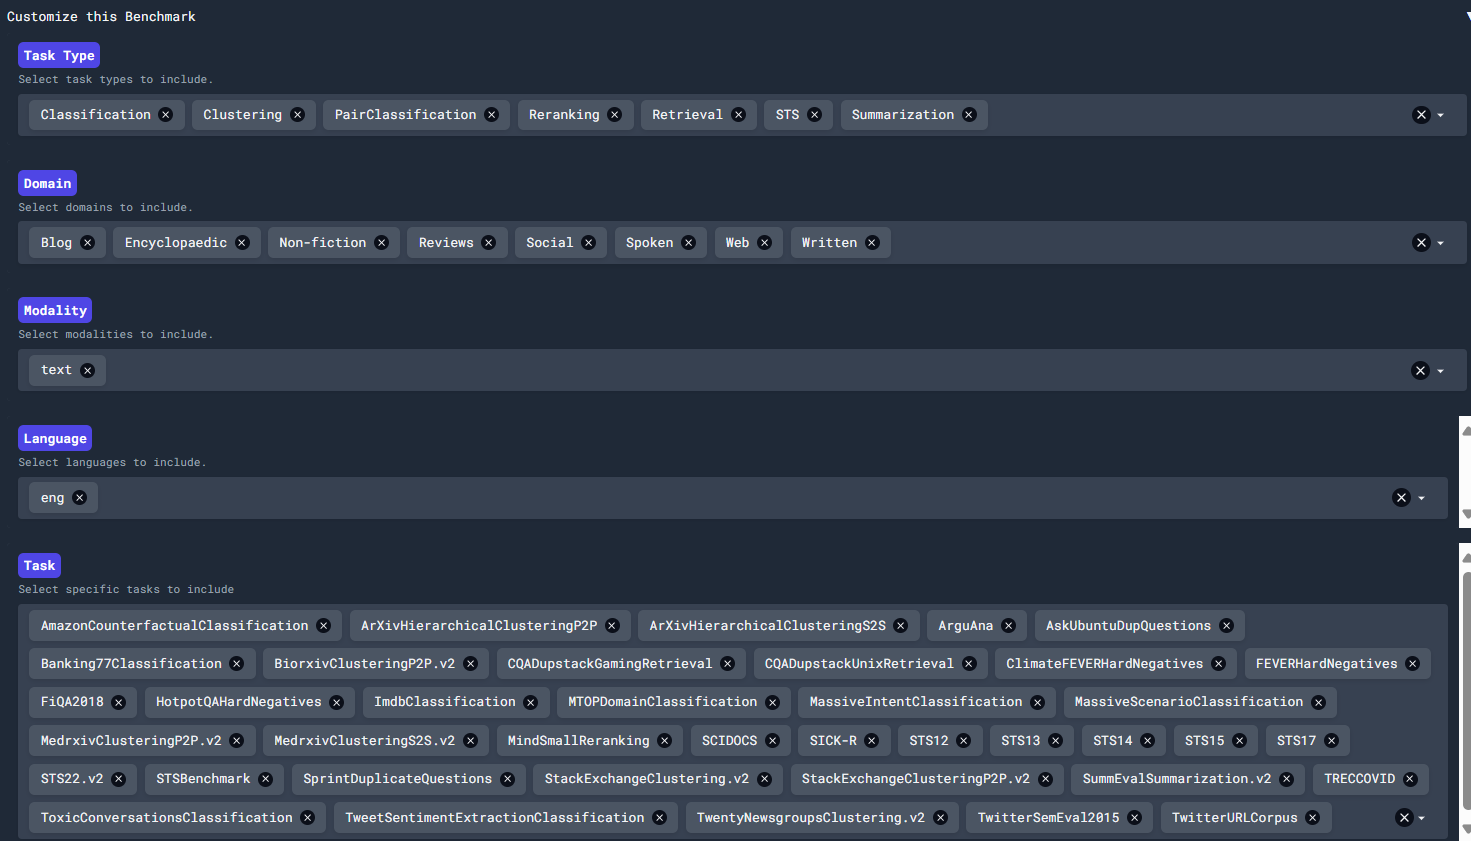

These are the results based on our filters : we can see that the family of text-embedding models from google are scoring an advanced rank

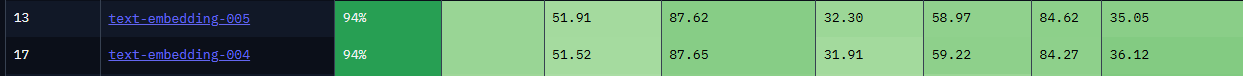



In [1]:
import os
import vertexai
from dotenv import load_dotenv
from vertexai.language_models import TextEmbeddingModel
import json
import time
import random
from tqdm import tqdm
from pathlib import Path

# Load environment variables
load_dotenv()

True

In [ ]:

# === CONFIG ===
PROJECT_ID = os.environ.get("GOOGLE_CLOUD_PROJECT")
LOCATION = os.environ.get("GOOGLE_CLOUD_LOCATION")

INPUT_PATH = Path("./data/chunks_cleaned.json")      
OUTPUT_PATH = Path("./data/embeddings.json")

### INIT VERTEX AI

In [ ]:
try:
    vertexai.init(project=PROJECT_ID, location=LOCATION)
    print(f"Vertex AI initialized ( location={LOCATION})")
except Exception as e:
    raise RuntimeError(f"Failed to initialize Vertex AI: {str(e)}")


Vertex AI initialized ( location=us-central1)


In [ ]:
# === LOAD DATA ===
with open(INPUT_PATH, "r", encoding="utf-8") as f:
    chunks = json.load(f)["chunks"]

print(f"Loaded {len(chunks)} chunks from {INPUT_PATH}")

Loaded 227 chunks from data\chunks_cleaned.json


In [13]:
print(chunks[0]['cleaned_text'])

empower ai innovation data analytics cloud excellence unleash creativity efficiency see understand act data navigate cloud journey confidence cloud ai solutions complete technology value-chain consulting migration start cloud journey consulting migration services assess migrate establish secure scalable cloud environment tailored needs aligned well-architected cloud principles make cloud transition straightforward effective cloud modernization transform business agile secure cloud solutions expertise serverless architectures devops cloud-native development aws azure google cloud empowers cut costs scale seamlessly drive innovation artificial intelligence partner industry leaders deliver custom ai strategies solutions drive measurable results strategy consulting model development deployment management expert team ensures success every stage data analytics unleash power data expert team help transform raw data actionable insights driving informed decision-making optimizing business opera

In [14]:
# === LOAD EMBEDDING MODEL ===
embedding_model = TextEmbeddingModel.from_pretrained(
    "publishers/google/models/text-embedding-005"
)

**This code** : 

* **Defines parameters**

  * `BATCH_SIZE = 2`: how many chunks to process in one batch (comment suggests 15–20 in practice).
  * `BATCH_DELAY = (10, 15)`: random wait time between batches (10–15 seconds).
  * `REQUEST_DELAY = (1, 2)`: random wait time between individual requests (1–2 seconds).
  * `NEW_CHUNKS_LIMIT = 30`: maximum number of new chunks to process in this run.
  * `OUTPUT_PATH`: path where embeddings are stored (`./data/embeddings.json`).

* **Ensures the output file exists**

  * If `embeddings.json` does not exist, it creates it and initializes it with an empty list.

* **Loads already saved embeddings**

  * Opens the file and loads existing embeddings into `embeddings_output`.
  * Extracts a set of `processed_ids` to quickly check if a chunk was already processed.

* **Tracks new additions**

  * Initializes `new_chunks_added = 0` to keep count of how many fresh chunks are processed in this run.

* **Processes chunks in batches**

  * Loops through `chunks` in increments of `BATCH_SIZE`.
  * Stops early if `NEW_CHUNKS_LIMIT` is reached.
  * For each batch:

    * Creates a list `batch_results` to hold embeddings for this batch.
    * Uses `tqdm` to show a progress bar.

* **Processes each chunk inside a batch**

  * Skips chunks if their `chunk_id` is already in `processed_ids`.
  * Stops if `NEW_CHUNKS_LIMIT` is reached.
  * Extracts `cleaned_text` and `original_text`.
  * Calls `embedding_model.get_embeddings([cleaned])` to generate an embedding vector.
  * Stores results (`chunk_id`, texts, embedding) into `batch_results`.
  * Marks this chunk as processed, increments `new_chunks_added`.
  * Waits a random delay (`REQUEST_DELAY`) between requests.

* **Saves batch results incrementally**

  * If the batch produced results, appends them to `embeddings_output`.
  * Writes the full updated `embeddings_output` back to `embeddings.json` (so progress is not lost if the script stops).
  * Prints how many total chunks are saved so far.

* **Adds a delay between batches**

  * If the batch had new chunks, waits a random delay (`BATCH_DELAY`) before moving to the next batch.



The stored result for each chunk in the JSON contains:

chunk_id → unique identifier for the chunk

cleaned_text → the text used to generate the embedding

original_text → the original unprocessed text (kept for reference)

embedding → the generated embedding vector

So embeddings are only computed for cleaned_text, while original_text is saved alongside for context/reference.

In [ ]:
# Parameters
BATCH_SIZE = 2           # 15-20
BATCH_DELAY = (10, 15)   # seconds between batches
REQUEST_DELAY = (1, 2)   # seconds between individual requests
NEW_CHUNKS_LIMIT = 30    # number of new chunks to process

OUTPUT_PATH = Path("./data/embeddings.json")

# Make sure the output file exists
if not OUTPUT_PATH.exists():
    with open(OUTPUT_PATH, "w") as f:
        json.dump([], f)

# Load already saved embeddings to avoid duplicates
with open(OUTPUT_PATH, "r") as f:
    embeddings_output = json.load(f)

# Keep track of chunk IDs we've already processed
processed_ids = {chunk["chunk_id"] for chunk in embeddings_output}

# Count how many new chunks we've added
new_chunks_added = 0

# Process chunks in batches
for i in range(0, len(chunks), BATCH_SIZE):
    if new_chunks_added >= NEW_CHUNKS_LIMIT:
        break  # stop once we've added enough new chunks

    batch = chunks[i:i + BATCH_SIZE]
    batch_results = []
    batch_has_new = False  # track if this batch has any new chunk

    for chunk in tqdm(batch, desc=f"Processing batch {i//BATCH_SIZE + 1}"):
        chunk_id = chunk["chunk_id"]
        if chunk_id in processed_ids:
            continue  # skip already processed chunks

        if new_chunks_added >= NEW_CHUNKS_LIMIT:
            break  # stop if we've reached the new chunk limit

        cleaned = chunk["cleaned_text"]
        original = chunk["original_text"]

        # Generate embedding for cleaned text
        embedding_vector = embedding_model.get_embeddings([cleaned])[0].values

        # Store result for this batch
        batch_results.append({
            "chunk_id": chunk_id,
            "cleaned_text": cleaned,
            "original_text": original,
            "embedding": embedding_vector
        })

        processed_ids.add(chunk_id)
        new_chunks_added += 1
        batch_has_new = True  # mark that this batch had new data

        # Delay between individual requests
        time.sleep(random.uniform(*REQUEST_DELAY))

    # Append batch results to main list and save incrementally
    if batch_results:
        embeddings_output.extend(batch_results)
        with open(OUTPUT_PATH, "w") as f:
            json.dump(embeddings_output, f, indent=2)
        print(f"Batch {i//BATCH_SIZE + 1} saved. Total chunks saved: {len(embeddings_output)}")

    # Delay between batches only if this batch had new chunks
    if batch_has_new and i + BATCH_SIZE < len(chunks):
        time.sleep(random.uniform(*BATCH_DELAY))

print(f"All done! Generated embeddings for {len(embeddings_output)} chunks in total.")


Processing batch 113: 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


Batch 113 saved. Total chunks saved: 226


Processing batch 114: 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


Batch 114 saved. Total chunks saved: 227
All done! Generated embeddings for 227 chunks in total.


### This code pushes the embeddings to qdrant to http://localhost:6333/collections/digibot_embeddings/points

In [ ]:
import json
import requests
import os

# Load your JSON file
with open("./data/embeddings.json", "r") as f:
    data = json.load(f)

# Prepare vectors in Qdrant format
vectors = []
for entry in data:
    vectors.append({
        "id": entry["chunk_id"],
        "vector": entry["embedding"],
        "payload": {
            "original_text": entry["original_text"]
        }
    })

# Push to Qdrant
QDRANT_URL = "http://localhost:6333"
COLLECTION_NAME = "digibot_embeddings"

# Qdrant supports batch inserts
batch_size = 100  # Adjust if needed
for i in range(0, len(vectors), batch_size):
    batch = vectors[i:i+batch_size]
    response = requests.put(
        f"{QDRANT_URL}/collections/{COLLECTION_NAME}/points",
        headers={"Content-Type": "application/json"},
        data=json.dumps({"points": batch})
    )
    if response.status_code == 200:
        print(f"Inserted batch {i} to {i+len(batch)-1}")
    else:
        print(f"Error inserting batch {i} to {i+len(batch)-1}: {response.text}")